## Задача по предсказанию рейтинга ресторана на основе базы данных с сайта TripAdvisor.
## Основная задача в feature engineering, для улучшения точности регрессионной модели.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [10]:
#Проверяем, где есть NaN значения.
print(df.isnull().sum())
#Проверяем, где есть числовые данные или списки.
df.dtypes

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
Cities                   0
dtype: int64


Restaurant_id         object
City                  object
Cuisine Style         object
Ranking              float64
Price Range           object
Number of Reviews    float64
Reviews               object
URL_TA                object
ID_TA                 object
sample                 int64
Rating               float64
Cities                object
dtype: object

In [11]:
#Сохраним все столбцы с параметрами NaN в свои отдельные столбцы
df['Cuisine Style is NaN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Number of Reviews is NaN']= pd.isna(df['Number of Reviews']).astype('uint8')
df['Price Range is NaN'] = pd.isna(df['Price Range']).astype('uint8')
df['Reviews are NaN'] = pd.isna(df['Reviews']).astype('uint8')

#Заполним NaN соответствующими значениями
df['Cuisine Style'].fillna(value="'European'", inplace = True)
df['Price Range'].fillna(value='no info', inplace = True)
df['Number of Reviews'].fillna(value=0, inplace = True)
df['Reviews'].fillna(value='no review', inplace = True)
df.isna().count()

#Закодируем значения по кухням.
le = LabelEncoder()
le.fit(df['Cuisine Style'])
df['Cuisine Style_code'] = le.transform(df['Cuisine Style'])

In [12]:
#Смотрим, сколько разных ценовых категорий
df['Price Range'].value_counts(dropna = False)
#Сколько ресторанов в средней ценовой категории
df[df['Price Range']=='$$ - $$$'].count()
#Смотрим, сколько разных городов
len(df.City.unique())

#Удаляем лишние символы из списка кухонь
df['Cuisine Style'] = df['Cuisine Style'].str.replace('[','')
df['Cuisine Style'] = df['Cuisine Style'].str.replace(']','')
df['Cuisine Style'] = df['Cuisine Style'].str.replace(', ',',')
df['Cuisine Style'] = df['Cuisine Style'].str.replace("'","")
#Смотрим, скоьлко в среднем кухонь
print(len(df['Cuisine Style'].str.split(',').explode())/len(df))

#Смотрим, сколько разных кухонь
print(df['Cuisine Style'].str.split(',').explode().value_counts())

#Выделим даты из ревью
df['Review Dates'] = df['Reviews'].apply(lambda x: re.sub(r'[^0-9/]+', r'',x).split(', '))

#Стобец с количеством разных кухонь для ресторана
df['Options Number']=df['Cuisine Style'].str.split(',').apply(lambda x: len(x))

#Среднее количество кухонь по городам
df['Mean Cuisines'] = df['City'].map(df.groupby('City')['Options Number'].mean())

#Вводим столбцы с соответствующими кухнями
for cuisine in list(df['Cuisine Style'].str.split(',').explode().value_counts().keys()):
    df[cuisine] = df['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0 ) 

2.62532
European               24151
Vegetarian Friendly    14021
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Polynesian                 2
Burmese                    1
Latvian                    1
Xinjiang                   1
Salvadoran                 1
Name: Cuisine Style, Length: 125, dtype: int64


In [13]:
#Сколько дней между отзывами
pattern = re.compile('\d\d/\d\d/\d\d\d\d')
def diff_rev_data(cell):
    data_set = pattern.findall(cell)
    if len(data_set) ==2:
        data1 = datetime.strptime(data_set[0],'%m/%d/%Y')
        data2 = datetime.strptime(data_set[1],'%m/%d/%Y')
        return(data1-data2).days
    if len (data_set)==1:
        return int((datetime.strptime(data_set[0], '%m/%d/%Y')).strftime('%d'))
    else:
        return 0
df['diff_rev_data']=df['Reviews'].apply(diff_rev_data)
df['diff_rev_data'].max()

3296

In [14]:
#Определение относительного ранга ресторана, в зависимости от города
rest_count = df.City.value_counts()
def get_rest_count(value):
    return rest_count[value]
#чем больше к единице, тем выше ранг ресторана
df['relative_ranking'] = 1-(df['Ranking'] / df['City'].map(df.groupby(['City'])['Ranking'].max()))

In [15]:
#Средняя цена по городу
df['Price Range'].value_counts()
replace_price_range = {'$$ - $$$':1,'$':0,'$$$$':2,'no info':1}
df['Price Range'] = df['Price Range'].map(lambda x: replace_price_range.get(x,x))
df['Mean Price'] = df['City'].map(df.groupby('City')['Price Range'].mean())
df['Price Range'].value_counts(dropna=False)

1    40402
0     7816
2     1782
Name: Price Range, dtype: int64

In [17]:
#Находится ли ресторан в столице
capitals = ['London','Paris','Madrid','Berlin','Rome','Prague','Lisbon','Vienna','Amsterdam',
            'Brussels','Stockholm','Budapest','Warsaw','Copenhagen','Athens','Dublin','Oslo','Helsinki',
            'Bratislava','Luxembourg','Ljubljana','Edinburgh']
def check_if_capital(value):
    return 1 if value in capitals else 0
df['In capital'] = df['City'].apply(check_if_capital)

#В каком городе находится ресторан
df['Cities'] = df['City']
df = pd.get_dummies(df, columns=['Cities'], drop_first = False,dummy_na = True)

In [18]:
#Признак уникальности ресторана из его номера на TripAdvisor
df['code_after_g_URL_TA'] = df['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')
#данные взяты из Википедии
population_density = {'Paris': 20781, 'Stockholm': 5139.7, 'London': 5667, 'Berlin': 4088, 'Munich': 4713, 'Oporto': 5703,
       'Milan':7588.97, 'Bratislava':1171, 'Vienna':4502.88, 'Rome':2234, 'Barcelona':15779, 'Madrid':8653.5,
       'Dublin':3689, 'Brussels':5497, 'Zurich':4666, 'Warsaw':3449, 'Budapest':3330.5, 'Copenhagen':6214.7,
       'Amsterdam':4768, 'Lyon':10041, 'Hamburg':2388.57, 'Lisbon':6243.9, 'Prague':2506, 'Oslo':1483.41,
       'Helsinki':899, 'Edinburgh':4140, 'Geneva':12589, 'Ljubljana':1736, 'Athens':7500,
       'Luxembourg':2240, 'Krakow':2344}

df['population_density'] = df['City'].map(population_density)
#данные взяты из Википедии
average_income = {'Paris': 3332, 'Stockholm': 2893, 'London': 2703, 'Berlin': 4392, 'Munich': 4392, 'Oporto': 1288,
       'Milan':2726, 'Bratislava':1283, 'Vienna':2940, 'Rome':2726, 'Barcelona':2133, 'Madrid':2133,
       'Dublin':3671, 'Brussels':3930, 'Zurich':6244, 'Warsaw':1253, 'Budapest':1187, 'Copenhagen':6192,
       'Amsterdam':3238, 'Lyon':3332, 'Hamburg':4392, 'Lisbon':1288, 'Prague':1454, 'Oslo':5450,
       'Helsinki':3908, 'Edinburgh':2703, 'Geneva':6244, 'Ljubljana':1914, 'Athens':1203,
       'Luxembourg':5854, 'Krakow':1253}
df['average_income'] = df['City'].map(average_income)

In [19]:
#В какой стране находится ресторан
city_country = {
        'London': 'UK',
        'Paris': 'France',
        'Madrid': 'Spain',
        'Barcelona': 'Spain',
        'Berlin': 'Germany',
        'Milan': 'Italy',
        'Rome': 'Italy',
        'Prague': 'Czech',
        'Lisbon': 'Portugalia',
        'Vienna': 'Austria',
        'Amsterdam': 'Nederlands',
        'Brussels': 'Belgium ',
        'Hamburg': 'Germany',
        'Munich': 'Germany',
        'Lyon': 'France',
        'Stockholm': 'Sweden',
        'Budapest': 'Hungary',
        'Warsaw': 'Poland',
        'Dublin': 'Ireland',
        'Copenhagen': 'Denmark',
        'Athens': 'Greece',
        'Edinburgh': 'Schotland',
        'Zurich': 'Switzerland',
        'Oporto': 'Portugalia',
        'Geneva': 'Switzerland',
        'Krakow': 'Poland',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Bratislava': 'Slovakia',
        'Luxembourg': 'Luxembourg',
        'Ljubljana': 'Slovenija'
    }

df['County Code'] = df['City'].map(city_country)

le = LabelEncoder()

le = LabelEncoder()
le.fit(df['County Code'])
df['County Code'] = le.transform(df['County Code'])

In [20]:
#Количество ресторанов в городе
df['Rests per City'] = df['City'].map(
    df.groupby(['City'])['Restaurant_id'].count().to_dict())
df.drop(['Restaurant_id'], axis=1, inplace=True)

#Количество ресторанов по отношению к плотности населения
df['Rests per Density'] = df['Rests per City'] / df['population_density']

In [21]:
#Количество ревью по городам
df['Number of Reviews'].fillna(df['Number of Reviews'].mean(), inplace=True)
df['fb per City'] = df['Number of Reviews'].map(
    df.groupby(['Number of Reviews'
                ])['Number of Reviews'].count().to_dict())

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [22]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.select_dtypes(include = ['float64', 'int64', 'uint8'])
X = X.drop(['Rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((10000, 217), (40000, 217), (40000, 210), (32000, 210), (8000, 210))

In [23]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2039325


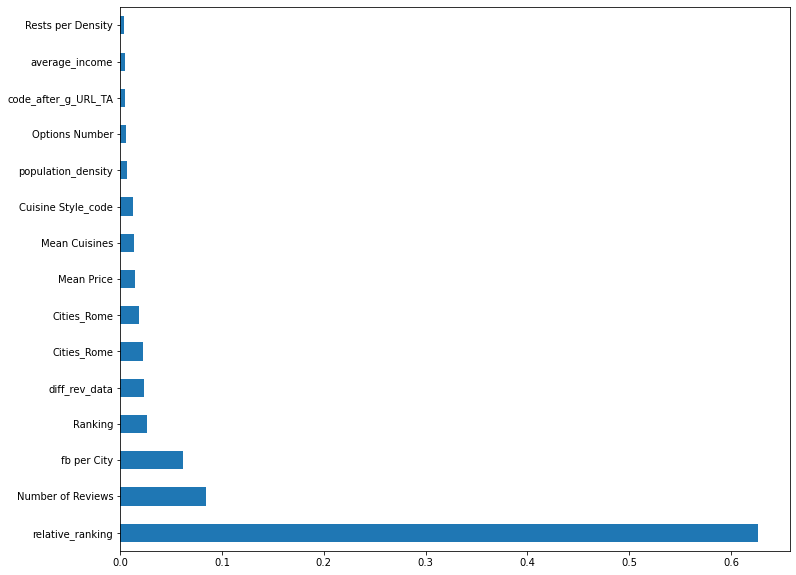

In [24]:
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [25]:
# Округлим результаты работы модели:
def round_to_half(row):
    return (round(row*2)/2)

new_round = np.vectorize(round_to_half)
y_pred_round = new_round(regr.predict(X_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.17385


In [34]:
test_data = test_data.select_dtypes(include = ['float64', 'int64', 'uint8'])
predict_submission = regr.predict(test_data)
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.135
1,id_1,4.145
2,id_2,4.520
3,id_3,4.385
4,id_4,4.475
5,id_5,4.395
6,id_6,1.140
7,id_7,2.905
8,id_8,4.180
9,id_9,4.485
